# WeRateDogs Twitter Feed

This project looks at various data sources for Tweets from the [WeRateDogs](https://twitter.com/dog_rates) Twitter account, specifically:

1. the `twitter-archive-enhanced.csv` which contains the tweet text, as is the core data set
1. the Twitter API is used to access the original tweets to retrieve missing fields such as the retweet and favorite counts
1. an image prediction file containing the top 3 predictions for each of the (up to 4) dog pictures in the tweet


---

## GATHER DATA

We use a number of data assets including local files, remote files on web servers, and JSON payloads returned by the Twitter API.

In [1]:
!ls ./data

image-predictions.tsv        tweet-json.zip
tweet-json copy              twitter-archive-enhanced.csv


In [2]:
WE_RATE_DOGS_TWEETS_PATH = 'data/twitter-archive-enhanced.csv'
DOG_BREED_PREDICTIONS_SOURCE_URL = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

### Read the CSV data

Pandas `read_csv()` function is quite versatile when uploading data, and can be configured to handle different date formats, numeric data types, not available (NA) markers, etc. Getting this right upfront can save time, but requires the raw data in files to be eyeballed first. For this we can use command line tools like head & tail, or Excel, which allows column headings to be frozen, data to be sorted and searched, etc.

In [3]:
!head -n 11 {WE_RATE_DOGS_TWEETS_PATH}

tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
892420643555336193,,,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,,,,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
892177421306343426,,,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",,,,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
891815181378084864,,,2017-

In [4]:
!tail -n 1940 {WE_RATE_DOGS_TWEETS_PATH} | head -n 8

813142292504645637,,,2016-12-25 22:00:04 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Everybody stop what you're doing and look at this dog with her tiny Santa hat. 13/10 https://t.co/KK4XQK9SPi,,,,"https://twitter.com/dog_rates/status/813142292504645637/photo/1,https://twitter.com/dog_rates/status/813142292504645637/photo/1,https://twitter.com/dog_rates/status/813142292504645637/photo/1",13,10,None,None,None,None,None
813130366689148928,8.13127251579564e+17,4196983835.0,2016-12-25 21:12:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",I've been informed by multiple sources that this is actually a dog elf who's tired from helping Santa all night. Pupgraded to 12/10,,,,,12,10,None,None,None,None,None
813127251579564032,,,2016-12-25 21:00:18 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here's an anonymous doggo that appears to be very done w

Having looked at the raw data, we make the following observations:

1. tweet Ids are large integers, we need to select an approriate integer datatype so no accuracy is lost
1. some tweet Ids use floats, e.g.: `in_reply_to_status_id`, `in_reply_to_user_id`, with NaNs used as a Not Available marker, as mentioned above these need to be converted to integers
1. time stamps are close to ISO 8601 format, and are GMT 
1. some strings have embeded new line characters, `read_csv()` handles this, but it messes up commands like `wc -l`

Actions taken to address above observations:

* convert floating point tweets Ids to a 64-bit integer, retaining the Not Available representation
* specifcally tell Pandas which columns are dates

In [5]:
import yaml
import tweepy
import json

In [6]:
import numpy as np
import pandas as pd

Load the enhanced Twitter archive, using explicit data types for fields, instead of letting Pandas infer them. The [Twitter API](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/tweet-object) will define the data types for the Twitter fields, to which I add the data types for the "enhanced" fields.

To get around the fact that nullable numeric fields, by default, are interpreted by `read_csv()` as floats (so as to include NaN to represent null or Not Available), I am mapping optional tweet Ids to Pandas nullable integer data type.

In [7]:
feed_data_types = {
    'tweet_id': np.int64,
    'in_reply_to_status_id': 'Int64',
    'in_reply_to_user_id': 'Int64',
    'retweeted_status_id': 'Int64',
    'retweeted_status_user_id': 'Int64',
    'text': 'string',
    'expanded_urls': 'string',
    'rating_numerator': np.int32,
    'rating_denominator': np.int32,
    'name': 'string',
    'doggo': 'string',
    'floofer': 'string',
    'pupper': 'string',
    'puppo': 'string'
}

feed_date_cols = [
    'timestamp', 
    'retweeted_status_timestamp'
]

In [8]:
tweets_df = pd.read_csv(WE_RATE_DOGS_TWEETS_PATH,
                        index_col=['tweet_id'],
                        dtype=feed_data_types,
                        parse_dates=feed_date_cols)
tweets_df.shape

(2356, 16)

### Examine the core data set

The first discrepancy we note is that, according to the project motivation document, the main "archive contains basic tweet data for all 5000+ of their tweets" however that is clearly not the case as, having loaded it, the number of tweets is less than half that. As this is the master data set we have been provided with, this is the data we will go with, since it has been previously enhanced.

Just to double check this row count, we will run a line count on the input file, which should roughly match the number of rows in the data frame. Any discrepancy on counts is due to those embeded new line (NL) characters in the tweet text, as was previously mentioned.

In [9]:
!wc -l {WE_RATE_DOGS_TWEETS_PATH}

    2518 data/twitter-archive-enhanced.csv


In [129]:
# When displaying Pandas data frames in the Jupyter notebook, raise or remove any limits on number displayed
# Care is needed here, specially with row counts, as very large data sets may get transferred into the browser

pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

Now we can double check the column data types, against the data type mapping provided to `read_csv()`.

In [11]:
tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 892420643555336193 to 666020888022790149
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   in_reply_to_status_id       78 non-null     Int64              
 1   in_reply_to_user_id         78 non-null     Int64              
 2   timestamp                   2356 non-null   datetime64[ns, UTC]
 3   source                      2356 non-null   object             
 4   text                        2356 non-null   string             
 5   retweeted_status_id         181 non-null    Int64              
 6   retweeted_status_user_id    181 non-null    Int64              
 7   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 8   expanded_urls               2297 non-null   string             
 9   rating_numerator            2356 non-null   int32              
 10  rating_denominator          2

### Use Twitter API to enrich the core data set

Next we want to use the Twitter API to retrieve the original tweets, so that we can enrich our enhanced tweets data with the missing attributes previously dientified (`retweet_counts`, `favorite_counts`).

Having registered with Twitter as a developer, and obtained credentials and keys, we stored these in a private project directory and configuration file (which are excluded from our git repo, and thus won't be visible online in [github](https://github.com/benvens-udacity/wrangle-and-analyze-data/blob/main/wrangle_act.ipynb)).

We now use those credentials to authenticate with Twitter for API access.

In [12]:
def read_creds(conf_path):
    with open(conf_path, 'r') as cf:
        config = yaml.load(cf, Loader=yaml.FullLoader)
        return config

In [13]:
creds = read_creds('./config/private/creds.yaml')

In [14]:
consumer_key = creds['consumer_api']['key']
consumer_secret = creds['consumer_api']['secret']

In [15]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

In [16]:
access_token = creds['access_token']['token']
acess_secret = creds['access_token']['secret']

In [17]:
auth.set_access_token(access_token, acess_secret)

Next we will load the enrichment data in batches, for better performance, as API invocations are subject to significant network latency. Twitter also applies rate limiting to their APIs, so it is necessary to throttle the rate at which we make requests, and to retry any failed requests. Luckily, this can be handled automatically by the Tweepy library, by setting the `wait_on_rate_limit_notify` flag when configuring API connection.

Although we are enriching the core enhanced tweets archive, we will initially load the API data into a separate data frame, cleanup as necessary, and then merge into the main table.

In [18]:
api = tweepy.API(auth, wait_on_rate_limit_notify=True)

In [19]:
def process_batch(batch):
    idxs = []
    retweet_counts = []
    favorite_counts = []
    for status in batch:
        tweet = status._json
        idxs.append(tweet['id'])
        retweet_counts.append(tweet['retweet_count'])
        favorite_counts.append(tweet['favorite_count'])
    return np.array(idxs, dtype=np.int64), np.array([retweet_counts, favorite_counts], dtype=np.int64).T

In [20]:
indices = np.empty((0), dtype=np.int64)
rows = np.empty((0, 2), dtype=np.int64)

In [21]:
batch_size = 100
num_tweets = len(tweets_df.index)

In [22]:
%%time 
for batch_start in range(0, num_tweets, batch_size):
    batch_end = min(batch_start + batch_size, num_tweets)
    batch_tweet_ids = tweets_df.iloc[batch_start:batch_end].index.to_numpy().tolist()
    statuses = api.statuses_lookup(batch_tweet_ids, include_entities=False, map_=False)
    b_indices, b_rows = process_batch(statuses)
    indices = np.concatenate((indices, b_indices), axis=0)
    rows = np.concatenate((rows, b_rows), axis=0)

CPU times: user 817 ms, sys: 110 ms, total: 926 ms
Wall time: 10.8 s


In [23]:
tweet_counts_df = pd.DataFrame(index=indices, data=rows, 
                               columns=['retweet_counts', 'favorite_counts'], 
                               dtype='Int32').sort_index()
tweet_counts_df.index.name = 'tweet_id'
tweet_counts_df.shape

(2331, 2)

In [24]:
enriched_tweets_df = tweets_df.merge(tweet_counts_df, how='inner', on='tweet_id')
enriched_tweets_df.shape

(2331, 18)

Next we review the structure of the merged data frame. In particular, the number of rows should be unchanged (as you'd expect given it is a left join), and the 2 additional columns have been added on at the end, with some NA values reflecting tweets that have never been retweeted or favorited.

In [25]:
enriched_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 892420643555336193 to 666020888022790149
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   in_reply_to_status_id       78 non-null     Int64              
 1   in_reply_to_user_id         78 non-null     Int64              
 2   timestamp                   2331 non-null   datetime64[ns, UTC]
 3   source                      2331 non-null   object             
 4   text                        2331 non-null   string             
 5   retweeted_status_id         163 non-null    Int64              
 6   retweeted_status_user_id    163 non-null    Int64              
 7   retweeted_status_timestamp  163 non-null    datetime64[ns, UTC]
 8   expanded_urls               2272 non-null   string             
 9   rating_numerator            2331 non-null   int32              
 10  rating_denominator          2

### Read in and normalise image data set

Finally we need to load the image predictions data, so we can tidy it. We will read this data from the CloudFront URL, a opposed to the local file, to ensure we get the most up-to-date version.

In [26]:
img_preds_data_types = {
    'tweet_id': 'Int64',
    'jpg_url': 'string',
    'img_num': np.int32,
    'p1': 'string',
    'p1_conf': np.float32,
    'p1_dog': bool,
    'p2': 'string',
    'p2_conf': np.float32,
    'p2_dog': bool,
    'p3': 'string',
    'p3_conf': np.float32,
    'p3_dog': bool
}

In [27]:
# Load the TSV (not CSV) records, and tell read_csv() to use a tab as the field separator

img_preds_df = pd.read_csv(DOG_BREED_PREDICTIONS_SOURCE_URL,
                           index_col=['tweet_id'],
                           sep='\t', 
                           dtype=img_preds_data_types)
img_preds_df.shape

(2075, 11)

We can now briefly review the structure of this data frame: 

1. each row refers to an image
1. each image is numbered, as it is selected as one of up to 4 dog images that may be associated with each tweet
1. we then have the top 3 predictions for the image

Each prediction consists of the following information:

1. a predicted label or class (e.g.: the dog breed) tht describes that image
1. a confidence factor associated with the previous prediction, in the range 0.0 -> 1.0
1. a boolean indicator confirming if the predicted label is a dog breed, or some other object

Looking at the confidence factors for predictions p1 - p3, they appear to be listed in most confident to least confident order. Therefore we will use the column name numeric suffix to generate a ranking column, which we can later sort by (to preserve this decreasing confidence order).

This last attribute confirms that the image classifier used to generate these prediction was trained on a broad set of images, only a subset of which are dog images labelled with their corresponding dog breed. But on occasions the classifier may have interpreted a dog image as an object other than a dog.

In [28]:
img_preds_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2075 entries, 666020888022790149 to 892420643555336193
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   jpg_url  2075 non-null   string 
 1   img_num  2075 non-null   int32  
 2   p1       2075 non-null   string 
 3   p1_conf  2075 non-null   float32
 4   p1_dog   2075 non-null   bool   
 5   p2       2075 non-null   string 
 6   p2_conf  2075 non-null   float32
 7   p2_dog   2075 non-null   bool   
 8   p3       2075 non-null   string 
 9   p3_conf  2075 non-null   float32
 10  p3_dog   2075 non-null   bool   
dtypes: bool(3), float32(3), int32(1), string(4)
memory usage: 119.6+ KB


---

## ASSESS DATA

We have already assessed the core tweet data, and fixed some issues at load time. Lets now look at data quality and structural issues.

### Remedy data quality issues

Some of the issues we now want to remedy are: 

1. dog names and stages are extracted when found, otherwise the value _None_ is used
1. dog stages are predefined, so storing the stage name into the relevant stage columnis redundant information, all we require is a binary marker
1. the 'source' column is an HTML anchor with a link to http://twitter.com/download/iphone which is repeated for all rows, therefore we will drop the `source` column

So next we convert those dog stage columns into a boolean data type.

In [29]:
# Convert dog stage columns into a boolean data type

stage_cols = ['doggo', 'floofer', 'pupper', 'puppo']
enriched_tweets_df[stage_cols] = enriched_tweets_df[stage_cols].apply(lambda c: c.to_numpy() != 'None')

In [30]:
# Confirm that the relevant dog stage columns are booleans (not strings)

enriched_tweets_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2331 entries, 892420643555336193 to 666020888022790149
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   in_reply_to_status_id       78 non-null     Int64              
 1   in_reply_to_user_id         78 non-null     Int64              
 2   timestamp                   2331 non-null   datetime64[ns, UTC]
 3   source                      2331 non-null   object             
 4   text                        2331 non-null   string             
 5   retweeted_status_id         163 non-null    Int64              
 6   retweeted_status_user_id    163 non-null    Int64              
 7   retweeted_status_timestamp  163 non-null    datetime64[ns, UTC]
 8   expanded_urls               2272 non-null   string             
 9   rating_numerator            2331 non-null   int32              
 10  rating_denominator          2

In [31]:
# Drop uninformative 'source' column

enriched_tweets_df = enriched_tweets_df.drop(columns=['source'])
enriched_tweets_df.shape

(2331, 17)

### Remedy structural issues

The `expanded_urls` column, which stores the full length URL for shortened URLs that appear in the tweet, has a couple of issues, both quality and structure:

1. it can store multiple URLs per cell, as a comma separated string
1. the same URL can appear multiple times

As looking at the tweet text it is not obvious why the same URL can appear more than once, instead of storing a repetition count, we will just drop any duplicates. Since these URLs can now have a many-to-one relationship with the tweet in which they appear, we will store them in a separate data frame.

In [32]:
# Pull out rows containing one or more expanded URLs, as some rows have none

expanded_urls_ser = enriched_tweets_df.loc[enriched_tweets_df['expanded_urls'].isna() == False]['expanded_urls']

In [33]:
# Nested list comprehension to split multiple URL strings on comma separator, then create [tweet Id, URL] tuples

expanded_url_tuples = [(ix, url) for ix, urls in expanded_urls_ser.iteritems() for url in urls.split(',')]

In [34]:
expanded_url_df = pd.DataFrame(expanded_url_tuples, columns=['tweet_id', 'expanded_url'])

In [35]:
# Now drop duplicates and make 'tweet_id' the index for consistency with other data frames

expanded_url_df = expanded_url_df.drop_duplicates().set_index('tweet_id')

In [36]:
# Finally drop the original expanded_urls column

enriched_tweets_df = enriched_tweets_df.drop(columns='expanded_urls')

In [37]:
# Note that the index can contain duplicate entries (where a tweet has more than one URL)
# We compare duplicate and non-duplicate counts below

expanded_url_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2313 entries, 892420643555336193 to 666020888022790149
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   expanded_url  2313 non-null   object
dtypes: object(1)
memory usage: 36.1+ KB


In [38]:
len(expanded_url_df.index), len(expanded_url_df.index.unique())

(2313, 2272)

Finally we will tidy up the image predictions data. By applying the Tidy Data principles, we will remove variables (the prediction number) from the relevant column names.

In [39]:
def slice_pred_cols(df, numeric):
    preds_df = df[['jpg_url', 'img_num']]
    preds_df = preds_df.assign(pred_rank=numeric,
                               pred_class=img_preds_df[f'p{numeric}'],
                               pred_confidence=img_preds_df[f'p{numeric}_conf'],
                               pred_is_dog=img_preds_df[f'p{numeric}_dog'])
    return preds_df

In [40]:
len(img_preds_df.index)

2075

In [41]:
preds1_df = slice_pred_cols(img_preds_df, 1)
preds2_df = slice_pred_cols(img_preds_df, 2)
preds3_df = slice_pred_cols(img_preds_df, 3)
image_predictions_df = pd.concat([preds1_df, preds2_df, preds3_df]).sort_values(by=['tweet_id', 'pred_rank'])

As we are removing variables from the column names, we will end up with more rows. Since all top 3 predictions are always generated, we will have exactly 3 times the number of rows we started with, as reflected by the row counts above and below.

In [42]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6225 entries, 666020888022790149 to 892420643555336193
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   jpg_url          6225 non-null   string 
 1   img_num          6225 non-null   int32  
 2   pred_rank        6225 non-null   int64  
 3   pred_class       6225 non-null   string 
 4   pred_confidence  6225 non-null   float32
 5   pred_is_dog      6225 non-null   bool   
dtypes: bool(1), float32(1), int32(1), int64(1), string(2)
memory usage: 249.2 KB


---

## CLEAN DATA

We have already performed a few cleaning tasks, including correcting data types and eliminating redundant data.

### Address specific data cleaning requirements

Next we will clean up the data as specified under the section **Key Points**, in the Project Motivation page, specifically:

1. We drop retweets, [by definition](https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/overview/tweet-object) these are tweets where the `retweet_status` fields are populated
2. Since none of the remaining rows are retweets, any column related to retweets will only hold NA and are now redundant, so we drop these columns
3. We drop columns without images, i.e.: where the `tweet_id` does not appear in the images data frame

In [43]:
# Delete retweets based on the presence of a retweet time, the drop all redundant retweet related columns

enriched_tweets_df = enriched_tweets_df.loc[enriched_tweets_df['retweeted_status_timestamp'].isna()]
enriched_tweets_df = enriched_tweets_df.drop(columns=['retweeted_status_id', 
                                                      'retweeted_status_user_id', 
                                                      'retweeted_status_timestamp'])
enriched_tweets_df.shape

(2168, 13)

In [44]:
# Delete tweets without images

enriched_tweets_df = enriched_tweets_df.loc[enriched_tweets_df.index.intersection(img_preds_df.index, sort=None)]
enriched_tweets_df.shape

(1987, 13)

### Keep persistent copy of wrangled clean data

As there appear to be no tweets beyond August 1st, 2017 (most likely since we dropped tweets without images) we are now done with cleaning. We end the wranggling process by writing the clean data to a new set of clean data files.

In [45]:
# We now write the cleaned data frames into files, in a directory called 'clean'

enriched_tweets_df.to_csv('clean/twitter_archive_master.csv')
expanded_url_df.to_csv('clean/twitter_archive_urls.csv')
image_predictions_df.to_csv('clean/image_predictions.csv')

---

## Data insights and visualisation

In this section we look at the data and query it to obtain some insights. Specifically, we are interested in:

1. Finding the number of tweets with a score above 10/10, versus tweets with a score under 10/10
2. Identify the tweets where more than one dog stage appears
3. Looking for top breed predictions from the image classifier, which are still lower than 0.5

**Number of scores above and below 10/10**

In [136]:
((enriched_tweets_df['rating_numerator'] / enriched_tweets_df['rating_denominator']) > 1.0).sum(), \
((enriched_tweets_df['rating_numerator'] / enriched_tweets_df['rating_denominator']) <= 1.0).sum()

(1152, 835)

**Tweets with more than one dog stage in the tweet text**

In [133]:
stage_cols = ['doggo', 'floofer', 'pupper', 'puppo']
enriched_tweets_df.loc[enriched_tweets_df[stage_cols].sum(axis=1) > 1][['text'] + stage_cols]

,text,doggo,floofer,pupper,puppo
tweet_id,,,,,
733109485275860992,"Like father (doggo), like son (pupper). Both 12/10 https://t.co/pG2inLaOda",True,False,True,False
741067306818797568,This is just downright precious af. 12/10 for both pupper and doggo https://t.co/o5J479bZUC,True,False,True,False
751583847268179968,Please stop sending it pictures that don't even have a doggo or pupper in them. Churlish af. 5/10 neat couch tho https://t.co/u2c9c7qSg8,True,False,True,False
759793422261743616,"Meet Maggie &amp; Lila. Maggie is the doggo, Lila is the pupper. They are sisters. Both 12/10 would pet at the same time https://t.co/MYwR4DQKll",True,False,True,False
785639753186217984,This is Pinot. He's a sophisticated doggo. You can tell by the hat. Also pointier than your average pupper. Still 10/10 would pet cautiously https://t.co/f2wmLZTPHd,True,False,True,False
801115127852503040,This is Bones. He's being haunted by another doggo of roughly the same size. 12/10 deep breaths pupper everything's fine https://t.co/55Dqe0SJNj,True,False,True,False
802265048156610565,"Like doggo, like pupper version 2. Both 11/10 https://t.co/9IxWAXFqze",True,False,True,False
808106460588765185,Here we have Burke (pupper) and Dexter (doggo). Pupper wants to be exactly like doggo. Both 12/10 would pet at same time https://t.co/ANBpEYHaho,True,False,True,False
817777686764523521,"This is Dido. She's playing the lead role in ""Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple."" 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7",True,False,True,False


**Tweets where the top scoring breed prediction is below 0.5** 

In [137]:
dog_preds = image_predictions_df.loc[(image_predictions_df['pred_rank'] == 1) \
                                     & image_predictions_df['pred_is_dog']]

In [138]:
dog_preds[dog_preds['pred_confidence'] < 0.5]

,jpg_url,img_num,pred_rank,pred_class,pred_confidence,pred_is_dog
tweet_id,,,,,,
666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,1,Welsh_springer_spaniel,0.465074,True
666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,1,Rhodesian_ridgeback,0.408143,True
666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,1,miniature_poodle,0.201493,True
666073100786774016,https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg,1,1,Walker_hound,0.260857,True
666082916733198337,https://pbs.twimg.com/media/CT5m4VGWEAAtKc8.jpg,1,1,pug,0.489814,True
666094000022159362,https://pbs.twimg.com/media/CT5w9gUW4AAsBNN.jpg,1,1,bloodhound,0.195217,True
666102155909144576,https://pbs.twimg.com/media/CT54YGiWUAEZnoK.jpg,1,1,English_setter,0.298617,True
666273097616637952,https://pbs.twimg.com/media/CT8T1mtUwAA3aqm.jpg,1,1,Italian_greyhound,0.176053,True
666353288456101888,https://pbs.twimg.com/media/CT9cx0tUEAAhNN_.jpg,1,1,malamute,0.336874,True


Now we are going to generate some visualisations:

1. First, based on the top image prediction, look at the frequency distribution for the top 10 breeds only, based on number of tweets
2. Now look at the frequency distribution for the top 10 breeds only, based on aggregate number of favorites

**Distribution by number of tweets**

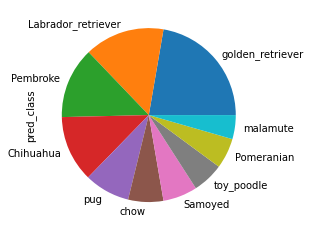

In [107]:
dog_preds['pred_class'].value_counts(sort=True)[0:10].plot.pie()

**Distribution by number of favorites**

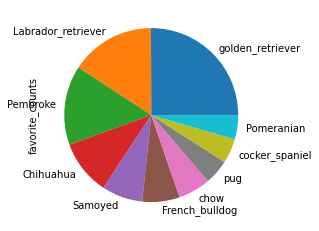

In [108]:
dog_preds.join(enriched_tweets_df['favorite_counts']).groupby(['pred_class']) \
    .sum().sort_values(by='favorite_counts', ascending=False)[0:10]['favorite_counts'].plot.pie()

### Generate internal report

Having cleaned the data, and generated data insights, we can now generate the internal documentation from this notebook's markdown cells.

(you probably want to clear all output previous to the data insights output generated the last section)

In [46]:
!jupyter nbconvert --no-input --to pdf wrangle_act.ipynb
!mv wrangle_act.pdf wrangle_report.pdf

[NbConvertApp] Converting notebook wrangle_act.ipynb to pdf
[NbConvertApp] Writing 47329 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 56891 bytes to wrangle_act.pdf


---